1. Loading the dataset

In [1]:
# 1.1. Launch commands to automatically reload modules
%load_ext autoreload
%autoreload 2

In [2]:
# 1.2. Import the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt

In [3]:
# 1.3. Load the training, validation and test datasets into a dataframes 
# Load the Parquet files into DataFrames
X_train = pd.read_parquet('../data/processed/X_train_resampled.parquet')
X_val = pd.read_parquet('../data/processed/X_val.parquet')
y_train = pd.read_parquet('../data/processed/y_train_resampled.parquet')
y_val = pd.read_parquet('../data/processed/y_val.parquet')
X_test = pd.read_parquet('../data/processed/test_cleaned.parquet')

In [4]:
# taking out the player id out of the test data
player_id_test = X_test.pop('player_id')

In [5]:
y_val = y_val.iloc[:, 0]  # Convert the single column DataFrame to a Series
y_val.shape

(9324,)

In [6]:
y_train = y_train.iloc[:, 0]  # Convert the single column DataFrame to a Series
y_train.shape

(37294,)

3. Support Vector Machines - Modelling

In [7]:
#3.1 Import SVM and instantiate the model
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

# Initialize the SVM model
svc1 = SVC(kernel='linear', probability=True)  


In [8]:
# 3.2 Train the model and save the predicted values
svc1.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [9]:
# Select the probability for the positive class (class 1)
y_train_probs_svc1 = svc1.predict_proba(X_train)[:, 1]
y_val_probs_svc1 = svc1.predict_proba(X_val)[:, 1]

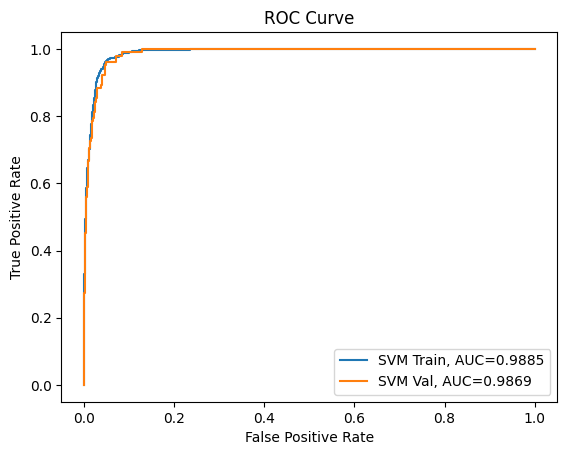

In [10]:
# 3.3 To plot ROC curve and the AUC metric - for comparison of model performances
from sklearn import metrics
from sklearn.metrics import roc_auc_score
#To plot ROC curve and the AUC metric

# Set up plotting area
plt.figure(0).clf()

# SVM - Train
fpr, tpr, _ = metrics.roc_curve(y_train, y_train_probs_svc1)
auc = round(metrics.roc_auc_score(y_train, y_train_probs_svc1), 4)
plt.plot(fpr, tpr, label="SVM Train, AUC="+str(auc))

# SVM - Validation
fpr, tpr, _ = metrics.roc_curve(y_val, y_val_probs_svc1)
auc = round(metrics.roc_auc_score(y_val, y_val_probs_svc1), 4)
plt.plot(fpr, tpr, label="SVM Val, AUC="+str(auc))

# Add legend
plt.legend()

# Show the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [11]:
# 3.4 Save the probability of the test data
y_test_probs_svc1 = svc1.predict_proba(X_test)[:, 1]


In [12]:
# 3.5 add the 'player_id'column  into the prediction probability
# Convert y_test_prob_rf3 (which is a NumPy array) to a DataFrame
y_test_probs_df = pd.DataFrame(y_test_probs_svc1, columns=['drafted'])

# Concatenate player_id_test and y_test_prob_df along the columns
Results_1 = pd.concat([player_id_test, y_test_probs_df], axis=1)

In [13]:
Results_1

,player_id,drafted
0,23549e01-c1b3-4ca0-a0fd-de9b5d76276b,0.001856
1,52a518bb-b34a-4b43-adee-5e996cb853fa,0.001838
2,ad3d9117-b6bf-4675-ab97-3497acf3e555,0.009068
3,eaf66a5c-6f4c-4070-bc70-a99d731b3740,0.005640
4,55d07491-5bd1-447f-844e-9cb36eaa442e,0.018374
...,...,...
4965,28222513-8a1f-4a48-8fde-16888e9e11ce,0.000314
4966,c32a466d-7a66-47eb-805c-a94e328261bc,0.002110
4967,55f0ddef-9f29-47ae-87b5-da43c687d25c,0.001656
4968,460d6a42-5dbc-48f0-bc94-3650da83f345,0.001919


In [14]:
#3.6 save the probability as CSV file

# Convert to DataFrame and save
pd.DataFrame(Results_1).to_csv('../data/external/smote_SVM_Results.csv', index=False)


#3.7 save the model
# Import dump from joblib
from joblib import dump

# 3.12 Save the model and call the files respectively SVM.joblib 
dump(svc1, '../models/SVM_smote.joblib')


['../models/SVM_smote.joblib']